# CAB420 Assignment 1B Question 2: Template

## Overview

This notebook provides a helper function to load in the Oxford-IIIT Pets dataset suitable for classification and semantic segmentation, to help with Assignment 1B, Question 2.

It also provides an example of how to load in the MobileNetV3Small Network which you are required to fine tune for the second part of the question.

Please read the comments and instructions within this notebook. It has been carefully designed to help you with many of the tasks required.

Please make sure you read the assignment brief on canvas, and check the FAQ for other information.

In [1]:
!pip install --upgrade tensorflow_datasets
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
from matplotlib import gridspec

import tensorflow as tf
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten
from keras.models import Model

import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import glob

E0000 00:00:1746866700.515246      73 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746866700.519259      73 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data loading and pre-processing functions

We first provide some helper functions to format the data in the way we need. You shouldn't need to change these, though you are welcome to if you like.

One thing you may want to do is create additional augmentation functions, and the ``flip_lr_augmentation`` function below could be used as a template to create additional augmentation types. 

In [3]:
def preprocess_segmentation_mask(segmentation_mask):
    """preprocess the semgentation mask

    The original segmentation mask has three categories.
      foreground, background and outline
    This function will just convert it to foreground and background 

    The original segmentation mask is also 1-index, so will convert it
    to 0-index.

    the original mask is represented as:
    1 - edge of dog/cat and things like leashes etc.
    2 - background
    3 - foreground

    we want to just keep the merge the edges and foreground of the doggo/catto, and
    then treat it as a binary semantic segmentation task.
    To achieve this, we will just subtract two, converting to values of [-1, 0, 1],
    and then apply the abs function to convert the -1 values (edges) to the foreground.

    Will also convert it to 32 bit float which will be needed for working with tf.
    
    Why am I doing it this way?
     A reasonable question. Initially I tried to do it with just normal array indexing,
     but this is a bit more work since the mask is a tensorflow tensor and not a np array.
     We could alternatively convert it to an array, perform indexing and then map it back,
     but this would have a performance overhead, which wouldn't be a big deal, but still.
     With all that being said, I am doing it for you, so you don't have to.

    Args:
      segmentation_mask (array):
        original segmentation mask

    Returns:
      preprocessed segmentation_mask
    """
    return tf.abs(tf.cast(segmentation_mask, tf.float32) - 2)

def return_image_label_mask(ds_out):
    """ function to return image, class label and segmentation mask

    The original dataset contains additional information, such as the filename and
    the species. We don't care about any of that for this work, so will
    discard them and just keep the original image as our input, and then
    a tuple of our outputs that will be the class label and the semantic
    segmentation mask.

    Whilst we are here, we will also preprocess the segmentation mask.

    Args:
      ds_out: dict
        original dataset output

    Returns:
       RGB image
       tuple of class label and preprocessed segmentation mask
    """
    # preprocess the segmentation mask
    seg_mask =  preprocess_segmentation_mask(ds_out['segmentation_mask'])
    image = tf.cast(ds_out['image'], tf.float32)
    # image = standardise_image(image)
    return image, (ds_out['label'], seg_mask)

def mobilenet_preprocess_image(image):
    """Apply preprocessing that is suitable for MobileNetV3.
    
    Simply scales to ranges [-1, 1]
    
    
    you should use this preprocessing for both your model and the mobilenet model
    """
    image = (image - 127.5) / 255.0
    return image
        
def unprocess_image(image):
    """ undo preprocessing above so can plot images"""
    image = image * 255.0 + 127.5
    return image

def preprocess_and_resize(image, output, image_size):
    """apply preprocessing steps above to images and resize images and maps
    
    Each image in the dataset is of a different size. The resizing will make sure
    each image is the same size.
    """
    # resize the image and the semantic segmentation mask
    image = tf.image.resize(image, [image_size, image_size])
    image = mobilenet_preprocess_image(image)
    mask = tf.image.resize(output[1], [image_size, image_size])
    return image, (output[0], mask)

def flip_lr_augmentation(image, output, flip_lr_prob):
    """ function to return perform left-right flip augmentation

    The function will flip the image along the left-right axis with
    a defined probability.
    """

    # randomly sample a value between 0 and 1
    uniform_sample = tf.random.uniform([], minval=0, maxval=1)
    # perform flip_lr with probability given by flip_lr_prob 
    flip_lr_cond = tf.math.less(uniform_sample, flip_lr_prob)
    # output is a tuple of (class, segmentation_mask), pull out the segmentation mask
    seg = output[1]
    
    # wrapper fn for when we do the flip
    def flip():
        flipped_image = tf.image.flip_left_right(image)
        flipped_seg = tf.image.flip_left_right(seg)
        return flipped_image, flipped_seg

    # wrapper fn for when we do NOT flip
    def no_flip():
        return image, seg

    # apply augmentation    
    image, seg = tf.cond(flip_lr_cond, flip, no_flip)
    # return the image, and output
    return image, (output[0], seg)

#--------------------------------------------------------------------------------------------------------------------- MY AUGMENTATIONS -----------------------------------------------------------------------------------------#
# define once at module level for reuse
_rotation_layer = tf.keras.layers.RandomRotation(
    factor=15/360,         # ±15° expressed as fraction of 360°
    fill_mode='constant'   # pad empty regions with zeros
)

def rotate_augmentation(image, output, rotate_prob):
    """
    Randomly rotate image + mask by up to ±15° with probability rotate_prob.
    Args:
      image:      3-D tensor [H, W, 3]
      output:     tuple (class_label, seg_mask) where seg_mask is [H, W, 1]
      rotate_prob: float in [0,1], chance to apply rotation
    Returns:
      image, (class_label, seg_mask)
    """
    # decide whether to rotate
    do_rotate = tf.less(tf.random.uniform([], 0, 1), rotate_prob)
    # pull out the mask
    seg = output[1]

    def _rot():
        # expand dims so layer accepts it
        img4 = tf.expand_dims(image, 0)
        seg4 = tf.expand_dims(tf.cast(seg, tf.float32), 0)

        # apply the same random rotation
        img_rot = _rotation_layer(img4, training=True)
        seg_rot_f = _rotation_layer(seg4, training=True)

        # squeeze back and round mask to nearest label
        img_out = tf.squeeze(img_rot, 0)
        seg_out = tf.cast(tf.round(tf.squeeze(seg_rot_f, 0)), seg.dtype)
        return img_out, seg_out

    def _id():
        return image, seg

    img_out, seg_out = tf.cond(do_rotate, _rot, _id)
    # re-pack original class label with transformed mask
    return img_out, (output[0], seg_out)
    
def translate_augmentation(image, output, translate_prob):
    """
    Randomly translate image+mask by up to ±10% of their actual width/height.
    """
    max_shift_frac = 0.1
    seg = output[1]

    do_translate = tf.less(tf.random.uniform([], 0, 1), translate_prob)

    def _trans():
        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        max_dx = tf.cast(max_shift_frac * tf.cast(w, tf.float32), tf.int32)
        max_dy = tf.cast(max_shift_frac * tf.cast(h, tf.float32), tf.int32)

        dx = tf.random.uniform([], -max_dx, max_dx + 1, dtype=tf.int32)
        dy = tf.random.uniform([], -max_dy, max_dy + 1, dtype=tf.int32)

        pad_top    = tf.maximum(dy, 0)
        pad_bottom = tf.maximum(-dy, 0)
        pad_left   = tf.maximum(dx, 0)
        pad_right  = tf.maximum(-dx, 0)

        img_pad = tf.pad(image,
                         [[pad_top, pad_bottom],
                          [pad_left, pad_right],
                          [0, 0]],
                         constant_values=0)
        seg_pad = tf.pad(seg,
                         [[pad_top, pad_bottom],
                          [pad_left, pad_right],
                          [0, 0]],
                         constant_values=0)

        # now crop back to the *actual* h, w
        img_t = tf.image.crop_to_bounding_box(img_pad,
                                              pad_bottom,  # shift up if dy<0, or start at 0 if dy>0
                                              pad_right,
                                              h, w)
        seg_t = tf.image.crop_to_bounding_box(seg_pad,
                                              pad_bottom,
                                              pad_right,
                                              h, w)
        return img_t, seg_t

    def _id():
        return image, seg

    img_out, seg_out = tf.cond(do_translate, _trans, _id)
    return img_out, (output[0], seg_out)
    
def zoomIn_augmentation(image, output, zoomIn_prob):
    """
    Randomly zoom in on the center of image + mask by up to 10%, with 50% chance.

    Args:
      image:      3-D tensor [H, W, 3]
      output:     tuple (class_label, seg_mask) where seg_mask is [H, W, 1]
      image_size: int, unused here (images may be arbitrary size)
    Returns:
      image, (class_label, seg_mask)
    """
    # probability and max zoom fraction
    zoom_prob      = zoomIn_prob
    max_zoom_frac  = 0.1  # up to 10% crop

    # decide whether to zoom
    uniform_sample = tf.random.uniform([], 0.0, 1.0)
    do_zoom        = tf.less(uniform_sample, zoom_prob)
    seg            = output[1]

    def _zoom():
        # pick a central fraction between (1 - max_zoom_frac) and 1.0
        central_frac = tf.random.uniform([], 1.0 - max_zoom_frac, 1.0)
        # crop central region
        img_crop = tf.image.central_crop(image, central_frac)
        seg_crop = tf.image.central_crop(seg,   central_frac)

        # get original dims
        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        # resize back to original
        img_resized = tf.image.resize(img_crop, [h, w], method='bilinear')
        seg_resized = tf.image.resize(seg_crop, [h, w], method='nearest')
        # cast mask back to original dtype
        seg_resized = tf.cast(seg_resized, seg.dtype)

        return img_resized, seg_resized

    def _no_zoom():
        return image, seg

    # apply zoom or not
    img_out, seg_out = tf.cond(do_zoom, _zoom, _no_zoom)

    # re-pack class label unchanged
    return img_out, (output[0], seg_out)
    
def saturation_augmentation(image, output, saturate_prob, lower=0.8, upper=1.2): # Photo metric jitter - helps with coat-pattern variation
    uniform_sample = tf.random.uniform([], 0, 1)
    do_saturate = tf.math.less(uniform_sample, saturate_prob)
    seg = output[1]

    def _saturate():
        # Sample a saturation factor in [lower, upper]
        factor = tf.random.uniform([], lower, upper)
        # adjust saturation
        img_sat = tf.image.adjust_saturation(image, factor)
        return img_sat, seg
    def _identity():
        return image, seg
    # Apply or skip
    image, seg = tf.cond(do_saturate, _saturate, _identity)
    return image, (output[0], seg)
#--------------------------------------------------------------------------------------------------------------------- MY AUGMENTATIONS -----------------------------------------------------------------------------------------#
def select_tasks(image, output, classification=True, segmentation=True):
    """select the tasks to include the data

    By default for each input there are two outputs. This function allows
    you to select which outputs to use, so the problem can be reduced to a
    single task problem for initial experimenting.    
    """
    # both tasks
    if classification and segmentation:
        return image, output
    # just classification
    elif classification:
        return image, output[0]
    # just segmentation
    elif segmentation:
        return image, output[1]
    # neither task, doesn't really make sense, so return the image
    # for a self-supervised task
    else:
        return image, image

class TrainForTime(keras.callbacks.Callback):
    """callback to terminate training after a time limit is reached

    Can be used to control how long training runs for, and will terminate
    training once a specified time limit is reached.
    """
    def __init__(
        self,
        train_time_mins=15,
    ):
        super().__init__()

        self.train_time_mins = train_time_mins
        self.epochs = 0
        self.train_time = 0
        self.end_early = False

    def on_train_begin(self, logs=None):
        # save the start time
        self.start_time = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        current_time = tf.timestamp()
        training_time = (current_time - self.start_time)
        if (training_time / 60) > self.train_time_mins:
            self.train_time = current_time - self.start_time
            self.model.stop_training = True
            self.end_early = True


    def on_train_end(self, logs=None):
        if self.end_early:
            print('training time exceeded and ending early')
            print(f'training ended on epoch {self.epochs}')
            print(f'training time = {self.train_time / 60} mins')

### Data Loader

We will now put the above functions together into a data loader that we can use to feed directly to the network. You can you this directly as it is. However, you may modify it to add some additional functionality such as further data augmentations.

In [5]:
def load_oxford_pets(split,
                     batch_size=128, #128 reaches upt to around ~3GB, which is sketchy, using 64 gets to 1.7GB which is better and allows us to keep imag_size of 128
                     classification=True,
                     segmentation=True,
                     shuffle=True,
                     augment=True,
                     image_size=64): # CHANGE HERE, we will use a size of 128
    """Load Oxford pets dataset for Assignment 1B

    Function handles loading of data for 1b, included processing of images and
    semantic segmentation masks. This function will
    organise the tensorflow dataset to return an output that is a tuple, where
    the tuple will be (classification_labels, segmentation_masks).

    Parameters
    ----------
    split : string
        either train, val or test string
    classification : bool
        whether to include classification labels
    segmentation : bool
        whether to include semantic segmentation masks
    batch_size : int
        size of batches to use
    shuffle : bool
        whether to shuffle the dataset (WILL ONLY APPLY TO TRAIN)
    augment : bool
        whether to augment the dataset (WILL ONLY APPLY TO TRAIN)
    image_size : int
        new image size

    Returns
    -------
       tf.Dataset containing the Oxford pets dataset
    """
    # lets do some error checking first
    # Check fior a valid dataset split, this must be train or test
    if (split != 'train') and (split != 'val') and (split != 'test'):
        raise ValueError('Arg for split must be either \'train\' or \'test\'')
    if (not classification) and (not segmentation):
        print("WARNING: One of the tasks (classification and segmentation) must be selected")
        print("Setting both to enabled")
        classification = True
        segmentation = True
        
    # check that if using the val split, shuffle if false. If not, print a warning and force shuffle to be false
    if (split == 'val') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be \'val\'")
        print('The shuffle argument will be ignored')
        shuffle = False
        
    # check that if using the test split, shuffle if false. If not, print a warning and force shuffle to be false
    if (split == 'test') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be \'test\'")
        print('The shuffle argument will be ignored')
        shuffle = False
        
    # check that if using the val split, augment if false. If not, print a warning and force augment to be false
    if (split == 'val') and augment:
        print("WARNING: augment is set to true, but have specified split to be \'val\'")
        print('The augment argument will be ignored')
        augment = False
        
    # check that if using the test split, augment if false. If not, print a warning and force augment to be false
    if (split == 'test') and augment:
        print("WARNING: augment is set to true, but have specified split to be \'test\'")
        print('The augment argument will be ignored')
        augment = False
        
    # the dataset by default only has train and test splits. If val is requested, pull the first 30% of the test set
    if (split == 'val'):
        split = 'test[:30%]'
    # the test set then becomes the remaining 70% of the original test set
    elif (split == 'test'):
        split = 'test[30%:]'
   
    # now start loading the dataset
    ds = tfds.load('oxford_iiit_pet',
                   split=split,
                   with_info=False)
    
    # remove unnecessary dataset info
    ds = ds.map(return_image_label_mask)

    # augmentation
    # only apply if in the training split and augment has been set to True
    if split == 'train' and augment:
        # apply a left-right flip with 50% probability
        flip_lr_prob = 0.5
        # flip operation
        ds = ds.map(lambda inp, out: flip_lr_augmentation(inp, out, flip_lr_prob), num_parallel_calls=tf.data.AUTOTUNE)

        # more augmentation operations could go here .....
        sat_prob = 0.4
        ds = ds.map(lambda inp, out: saturation_augmentation(inp, out, sat_prob), num_parallel_calls=tf.data.AUTOTUNE)
        rotate_prob = 0.2
        ds = ds.map(lambda img, out: rotate_augmentation(img, out, rotate_prob),num_parallel_calls=tf.data.AUTOTUNE)
        zoomIn_prob = 0.3
        ds = ds.map(lambda img, out: zoomIn_augmentation(img, out, zoomIn_prob), num_parallel_calls=tf.data.AUTOTUNE)
        translate_prob = 0.2
        ds = ds.map(lambda img, out: translate_augmentation(img, out, translate_prob),num_parallel_calls=tf.data.AUTOTUNE)

    # Final processing of the data 
    # here we will resize the data, and add the preprocessing that is needed for compatability with the mobilenet models.
    ds = ds.map(lambda inp, out: preprocess_and_resize(inp, out, image_size))

    # and now remove any tasks that we don't want. Note that we call this last as it means that all the other functions
    # can safely assume that data for both tasks is in the dataset
    ds = ds.map(lambda inp, out: select_tasks(inp, out, classification, segmentation))

    # if in the training split, and shuffle is true, shuffle the data
    if split == 'train' and shuffle:
        ds = ds.shuffle(1000)

    # return the loaded and processed dataset
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


### Testing the provided data loader.

We'll now test the data loader and plot some examples to confirm it's working. **NOTE: some poor defaults are specified below for image size and batch size. Set these to something more appropriate.**

In [7]:
# testing the data loader and plotting some images.
# NOTE: the image size set here is all but definitely too large. You will need
# to chage this yourself to something that is suitable given your constraints
# NOTE: The batch size is also too large. This done on purpose force you to 
# pick a suitable batch size yourself
image_size = 64
batch_size = 128
# load training data, note that shuffle and augment are true
train_class_seg = load_oxford_pets('train', classification=True, segmentation=True, shuffle=True, augment=True, 
                                   batch_size=batch_size, image_size=image_size)
# load validation data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
val_class_seg = load_oxford_pets('val', classification=True, segmentation=True, shuffle=False, augment=False, 
                                 batch_size=batch_size, image_size=image_size)
# load testing data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
test_class_seg = load_oxford_pets('test', classification=True, segmentation=True, shuffle=False, augment=False, 
                                  batch_size=batch_size, image_size=image_size)

(128, 64, 64, 1)
(128, 64, 64, 1)
(128, 64, 64, 1)


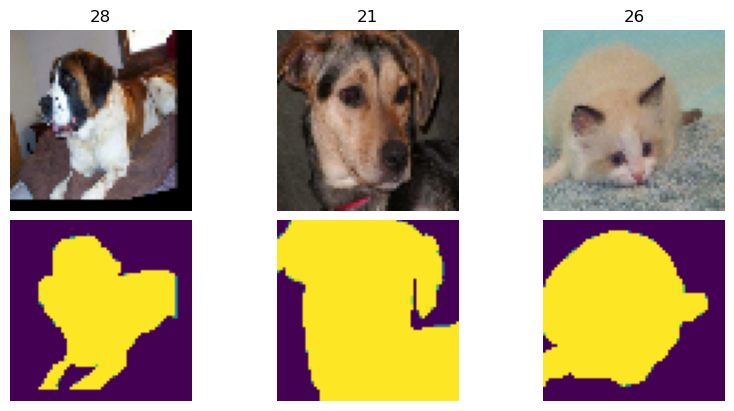

In [8]:
# lets plot a few now to see some good kittens/doggos
fig, axs = plt.subplots(2, 3, figsize=(8, 4), layout="constrained")
num_plot = 3
i = 0

# each sample of our dataset will be of the format
# image, outputs
# where outputs[0] = label
#       outputs[1] = segmentation mask
#
#
# lets get a single batch, and plot just a few of them
for image, output in train_class_seg.take(1).as_numpy_iterator(): 
    for i in range(num_plot): 
        im = axs[0, i].imshow(np.squeeze(unprocess_image(image[i, ...])) / 255.0)
        axs[0, i].set_title(output[0][i])
        axs[0, i].axis('off')
        im = axs[1, i].imshow(np.squeeze(output[1][i, ...]))
        axs[1, i].axis('off')
        
        print(output[1].shape)
        i += 1
        if i >= num_plot:
            break
        
plt.savefig('doggos_cattos.png')

The images are showing correctly.

**NOTE: You can ignore the JPEG wearning.**

We can use the ``classification`` and ``segmentation`` flags to pull out just one output as well, as the below demonstrates. 

In [ ]:
# classification only; classification = True, segmentation = False (note batch size is 1 here) JUST FOR VISUALISATION
train_class_only = load_oxford_pets('train', classification=True, segmentation=False, shuffle=True, augment=True, batch_size=1, image_size=image_size)
# segmentation only; classification = False, segmentation = True (note batch size is 1 here)
train_seg_only = load_oxford_pets('train', classification=False, segmentation=True, shuffle=True, augment=True, batch_size=1, image_size=image_size)

# test the classification only dataset
# pull out one element
inp, out = next(iter(train_class_only))
# print the output
print(out.numpy())

# test the segmentation only dataset
# pull out one element
inp, out = next(iter(train_seg_only))
# print just the output shape for the segmentation output 
print(out.numpy().shape)

While for the question you do need to train networks to do both tasks simultaenously, when you starting playing with the problem it might be easier to get things working for one task, and then add the second.

### Loading MobileNetV3Small base for fine tuning

This model can be loaded directly from keras. By default, the model we download will be pre-trained on Imagenet dataset.

Note that we will need to set the preprocessing option when loading this base network to False. This is because the `include_preprocessing` step is implemented in the Datasets we defined above.

We also set `include_top=False`, to avoid loading our model with the final Dense classification layer which is used for the original Imagenet model.

More details are available in the keras documentation [here](https://keras.io/api/applications/mobilenet/).

In [ ]:
mobile_base = keras.applications.MobileNetV3Small(input_shape=(64, 64, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)

For this task, can ignore the input_shape warning, though it is important to keep in mind the difference in size of data used for the pre-trained model and our data may have an impact on our model (what that impact might be is for you to investigate :) ). Depending on what input shape you select you may also be able to eliminate this.

For more information on fine-tuning models, can refer to many of the examples from class, or the [Keras documentation](https://keras.io/guides/transfer_learning/)

## Question 2 Template

The following provides a starting point for your solution, and some suggestions on how to proceed. 

**PLEASE READ THE COMMENTS CAREFULLY** There are a number of tips around how to proceed, and things to look out for.

In [6]:
#
# Data loading
#
# Use the provided data loader, setting your batch size and image size appropriately.
# Note that you may want to add more augmentation into the data loader.
# For initial experiments you may also want to turn one of classification or segmentation off to allow you to play with a single task.
image_size = 64
batch_size = 128
# load training data, note that shuffle and augment are true
train_class_seg = load_oxford_pets('train', classification=True, segmentation=True, shuffle=True, augment=True, 
                                   batch_size=batch_size, image_size=image_size)
# load validation data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
val_class_seg = load_oxford_pets('val', classification=True, segmentation=True, shuffle=False, augment=False, 
                                 batch_size=batch_size, image_size=image_size)
# load testing data, note that shuffle and augment are false (though if they weren't, the data loader would force these to be false)
test_class_seg = load_oxford_pets('test', classification=True, segmentation=True, shuffle=False, augment=False, 
                                  batch_size=batch_size, image_size=image_size)

# Note that you may also want a non-shuffled version of the training set to help you evaluate training performance. You could simply create another
# training set object with the same settings, but shuffle set to False, i.e.
# train_class_seg_ns = load_oxford_pets('train', classification=True, segmentation=True, shuffle=False, augment=True, 
#                                       batch_size=batch_size, image_size=image_size)

In [ ]:
# 
# From-scratch DCNN
#
# Put your from-scratch DCNN here. This network will have one input (the input image), and two outputs (the class, and the segmentation map). You can
# think of your model as having three components:
#  - A backbone, which is going to take your input and encode that. This will possibly be collection of (probably mostly) 2D convolution layers 
#    and max pooling layers (and for which you may be able to find something fairly fit for purpose in lecture or prac examples).
#  - A classification head, which will take the backbone output and via one or more dense layers do the classification task. This will likely only
#    be a few layers at most.
#  - A decoder head, which will do the semantic segmentation. This will look a lot like the back half of an autoencoder.
#
# As usual, the network does not need to be overly complex, but you will need to briefly explain your selection of this model, and you should avoid 
# networks so simple that they perform very badly.
#
# Take note of the order that the outputs appear in the data loader. The data loader will give you (classification_output, segmentation_output), so
# your network should have the outputs in the same order, and your losses should also be in the same order. With your losses, note that:
# * For the classification task ground truth data is being given as class labels, so you should use Sparse Categorical Cross Entropy.
# * For the segmentation loss, there are a few options you could use, but a good starting point is simply binary cross entropy, essentially
#   every pixel is a binary classification task (foreground or background)
# * The order of your losses is critical. The dataset object will give you (classification_targets, segmentation_targets). This means that you're 
#   network should it's outputs, and loss functions, in the same order - if you get this order wrong you will get weird errors
#
# When first developing your model, you may want to start by getting a single output of the network going, and then adding the second output. For
# example, you may build a network with the image input and the just the classification head, get that running, and then add the decoder head. You can
# use the classification and segmentation flags in the data loader to turn off one of the outputs.

# For model training, we have provided a callback, TrainForTime, which will terminate training after some time limit is reached. You could use this
# as follows:
#
#   train_time = 15 # 15-minute training limit
#   my_awesome_model.fit(train_class_seg, epochs=epochs, verbose=True, validation_data=val_class_seg, callbacks=[TrainForTime(train_time)])
#
# You don't have to use this, but you may wish to use this to ensure training doesn't take too long.
# Note that if you don't train until convergence, you will need to explain what you observe with training and what the implications of this are.

# Building the Network
Usefule Functions:
train_time = 15 # 15-minute training limit

my_awesome_model.fit(train_class_seg, epochs=epochs, verbose=True, validation_data=val_class_seg, callbacks=[TrainForTime(train_time)])

In [4]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Dense, Input, BatchNormalization, ReLU
from keras.models import Model

def build_network():
    input_img = Input(shape=(64, 64, 3))
    
    # First set of Conv2D layers with Batch Normalization
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Second set of Conv2D layers with Batch Normalization
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Third set of Conv2D layers with Batch Normalization
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Fourth set of Conv2D layers with Batch Normalization
    
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = Conv2D(8, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Fifth set of Conv2D layers with Batch Normalization
    x = Conv2D(4, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(4, (3, 3), padding='same')(x)
    x = Conv2D(4, (3, 3), padding='same')(x)
    x = Conv2D(4, (3, 3), padding='same')(x)
    x = Conv2D(4, (3, 3), padding='same')(x)
    x = Conv2D(4, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

    # Classification head
    class_out = Flatten()(encoded)
    class_out = Dense(37, activation='softmax', name='class_output')(class_out)

    # Segmentation Head (upsampling part)
    x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu')(encoded)  
    x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)      
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)       
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x) 
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x) 
    seg_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same', name='segmentation_output')(x)
    
    model = Model(inputs=input_img, outputs=[class_out, seg_out])
    return model

In [5]:
Model1 = build_network()

# Define your loss functions for each output
classification_loss = 'sparse_categorical_crossentropy'  # For classification task
segmentation_loss = 'binary_crossentropy'        # For segmentation task

Model1.compile(
    optimizer='adam',
    loss = {
        'class_output': classification_loss,
        'segmentation_output': segmentation_loss,
    },
    #loss_weights = loss_weights,
    metrics = {
        'class_output': 'accuracy',
        'segmentation_output': 'accuracy'
    })     
print(Model1.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     18,464 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      9,248 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d_7[0][0]  

 Total params: 335,686 (1.28 MB)

 Trainable params: 335,190 (1.28 MB)

 Non-trainable params: 496 (1.94 KB)

None


In [8]:
img_file = 'model1.png'
keras.utils.plot_model(Model1, to_file=img_file, show_shapes=True)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
train_time = 20

# Set up the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor the validation loss
    patience=10,              # Stop after 10 epochs of no improvement
    mode='min',               # 'min' means the training will stop when the val_loss stops decreasing
    verbose=1,                # Print a message when training stops
    restore_best_weights=True # Restore the best model weights when training stops
)

# Set up the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'JUstforgraph6.keras',                # Path where the model will be saved
    monitor='val_loss',             # Monitor validation loss (can also use 'val_accuracy')
    save_best_only=True,            # Only save the model if it improves
    mode='min',                     # 'min' means the model with the minimum validation loss will be saved
    verbose=1                        # Prints out when the model is saved
)

# Train the model with both callbacks
Model1_Layers = Model1.fit(
    train_class_seg,
    validation_data=val_class_seg,
    epochs=300,
    verbose=True, 
    callbacks=[checkpoint, TrainForTime(train_time)]  # Add early stopping to callbacks
)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[20, 15])

# Training losses
ax = fig.add_subplot(2, 2, 1)
ax.plot(Model1_Layers.history['loss'], label='Total Loss')
ax.plot(Model1_Layers.history['class_output_loss'], label='Classification Loss')
ax.plot(Model1_Layers.history['segmentation_output_loss'], label='Segmentation Loss')
ax.set_title('Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# Validation losses
ax = fig.add_subplot(2, 2, 2)
ax.plot(Model1_Layers.history['val_loss'], label='Val Total Loss')
ax.plot(Model1_Layers.history['val_class_output_loss'], label='Val Classification Loss')
ax.plot(Model1_Layers.history['val_segmentation_output_loss'], label='Val Segmentation Loss')
ax.set_title('Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# Training accuracies
ax = fig.add_subplot(2, 2, 3)
ax.plot(Model1_Layers.history['class_output_accuracy'], label='Classification Accuracy')
ax.plot(Model1_Layers.history['segmentation_output_accuracy'], label='Segmentation Accuracy')
ax.set_title('Training Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

# Validation accuracies
ax = fig.add_subplot(2, 2, 4)
ax.plot(Model1_Layers.history['val_class_output_accuracy'], label='Val Classification Accuracy')
ax.plot(Model1_Layers.history['val_segmentation_output_accuracy'], label='Val Segmentation Accuracy')
ax.set_title('Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import f1_score
from keras import backend as K

# List of file names for your saved models (including batch normalization models)
model_files = [
    '2_ConvLayers.keras',
    '2_ConvLayers_Batch_20Min.keras',
    '4_ConvLayers.keras', 
    '4_ConvLayers_Batch_20Min.keras', 
    '6_ConvLayers.keras', 
    '6_ConvLayers_Batch_20Min.keras', 
    '8_ConvLayers.keras',
    '8_ConvLayers_Batch_20Min.keras',
]

# Store the classification losses and classification accuracies for non-batched and batched models
class_losses = []
class_accuracies = []
class_losses_batched = []
class_accuracies_batched = []

# Load each model and evaluate
for model_file in model_files:
    model = load_model(model_file)
    
    # Evaluate the model on validation data
    evaluation_metrics = model.evaluate(val_class_seg, verbose=0)
    
    # Extract classification loss and accuracy
    class_loss = evaluation_metrics[1]  # Assuming classification loss is the second element
    class_accuracy = evaluation_metrics[3]  # Assuming classification accuracy is the fourth element
    
    # If the model name contains "Batch" it indicates a batch-normalized model
    if 'Batch' in model_file:
        class_losses_batched.append(class_loss)
        class_accuracies_batched.append(class_accuracy)
    else:
        class_losses.append(class_loss)
        class_accuracies.append(class_accuracy)

# Plot the results

# X-axis values for each depth group
x_non_batched = [2, 4, 6, 8]  # For non-batched models
x_batched = [2, 4, 6, 8]  # For batched models (same as above, since you have models at 2, 4, 6, and 8 layers)

# Plotting classification loss
plt.figure(figsize=(12, 6))

# Non-batched models (e.g., 2, 6 Conv Layers without Batch Normalization)
plt.subplot(1, 2, 1)
plt.plot(x_non_batched[:4], class_losses, marker='o', color='b', linestyle='-', label='Non-batched Models')
# Batched models (e.g., 4, 8 Conv Layers with Batch Normalization)
plt.plot(x_batched[:4], class_losses_batched, marker='o', color='r', linestyle='-', label='Batched Models')
plt.title('Classification Loss vs Model Depth (Batch Normalisation)')
plt.xlabel('Model Depth')
plt.ylabel('Classification Loss')
plt.legend()
plt.grid(True)

# Plotting classification accuracy
plt.subplot(1, 2, 2)
plt.plot(x_non_batched[:4], class_accuracies, marker='o', color='g', linestyle='-', label='Non-batched Models')
plt.plot(x_batched[:4], class_accuracies_batched, marker='o', color='orange', linestyle='-', label='Batched Models')
plt.title('Classification Accuracy vs Model Depth (Batch Normalisation)')
plt.xlabel('Model Depth')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Dense, Input, BatchNormalization, ReLU
from keras.models import Model

# Fine-tuned MobileNet
#
# Pur your mobilenet model here. This will have the same structure as the from-scratch network above, but now the backbone will be mobilenet rather
# than something of your own design. The classification and segmentation heads will possibly be quite similar to what you have above. As per the 
# from-scratch network, you may want to build this with just one output to start with, and then add the second when you get that working.
# load mobilenet backbone
image_size = 64
input_img = Input(shape=(image_size, image_size, 3))

mobile_base = keras.applications.MobileNetV3Small(input_shape=(image_size, image_size, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)
mobile_base.trainable = True # False = Frozen, True = Unfreeze the pre-trained models
    

x = mobile_base(input_img)

# Classifier Head
class_out = Flatten()(x)
class_out = Dense(37, activation='softmax', name='class_output')(class_out)

# Segmentation Head (upsampling part)
x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu')(x)  
x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)      
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)       
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x) 
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x) 
seg_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same', name='segmentation_output')(x)
    
model = Model(inputs=input_img, outputs=[class_out,seg_out])

# train the model. As per the from-scratch model, you may wish to use the callback - though if the model is not trained until convergence you will
# need to explain the implications of this.
# Compile the model (example with Adam optimizer and loss for both tasks)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              loss={'class_output': 'sparse_categorical_crossentropy', 'segmentation_output': 'binary_crossentropy'},
              metrics={'class_output': 'accuracy', 'segmentation_output': 'accuracy'})
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Small    │ (None, 2, 2, 576) │    939,120 │ input_layer_11[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_30 │ (None, 4, 4, 8)   │     41,480 │ MobileNetV3Small… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_31 │ (None, 8, 8, 16)  │      1,168 │ conv2d_transpose… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_32 │ (None, 16, 16,    │      4,640 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_33 │ (None, 32, 32,    │     18,496 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 2304)      │          0 │ MobileNetV3Small… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_34 │ (None, 64, 64,    │     36,928 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 37)        │     85,285 │ flatten_6[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segmentation_output │ (None, 64, 64, 1) │         65 │ conv2d_transpose… │
│ (Conv2D)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,127,182 (4.30 MB)

 Trainable params: 1,115,070 (4.25 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
train_time = 20

# Set up the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor the validation loss
    patience=10,              # Stop after 10 epochs of no improvement
    mode='min',               # 'min' means the training will stop when the val_loss stops decreasing
    verbose=1,                # Print a message when training stops
    restore_best_weights=True # Restore the best model weights when training stops
)

# Set up the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'Mobile_SmallLearningRateUnFreezeLayers.keras',                # Path where the model will be saved
    monitor='val_loss',             # Monitor validation loss (can also use 'val_accuracy')
    save_best_only=True,            # Only save the model if it improves
    mode='min',                     # 'min' means the model with the minimum validation loss will be saved
    verbose=1                        # Prints out when the model is saved
)

# Train the model with both callbacks
mobile_layers = model.fit(
    train_class_seg,
    validation_data=val_class_seg,
    epochs=150,
    verbose=True, 
    callbacks=[checkpoint, TrainForTime(train_time), early_stopping]  # Add early stopping to callbacks
)

Epoch 1/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - class_output_accuracy: 0.0296 - class_output_loss: 5.7549 - loss: 6.4480 - segmentation_output_accuracy: 0.5427 - segmentation_output_loss: 0.6928
Epoch 1: val_loss improved from inf to 5.11419, saving model to Mobile_SmallLearningRateUnFreezeLayers.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 55s 882ms/step - class_output_accuracy: 0.0298 - class_output_loss: 5.7549 - loss: 6.4482 - segmentation_output_accuracy: 0.5435 - segmentation_output_loss: 0.6928 - val_class_output_accuracy: 0.0300 - val_class_output_loss: 4.4281 - val_loss: 5.1142 - val_segmentation_output_accuracy: 0.5766 - val_segmentation_output_loss: 0.6916
Epoch 2/150
28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - class_output_accuracy: 0.0430 - class_output_loss: 5.0383 - loss: 5.7290 - segmentation_output_accuracy: 0.5806 - segmentation_output_loss: 0.6907
Epoch 2: val_loss improved from 5.11419 to 4.91144, saving model to Mobile_SmallLearningRateUnFreezeLayers.keras
29/29 ━━━━━━━━

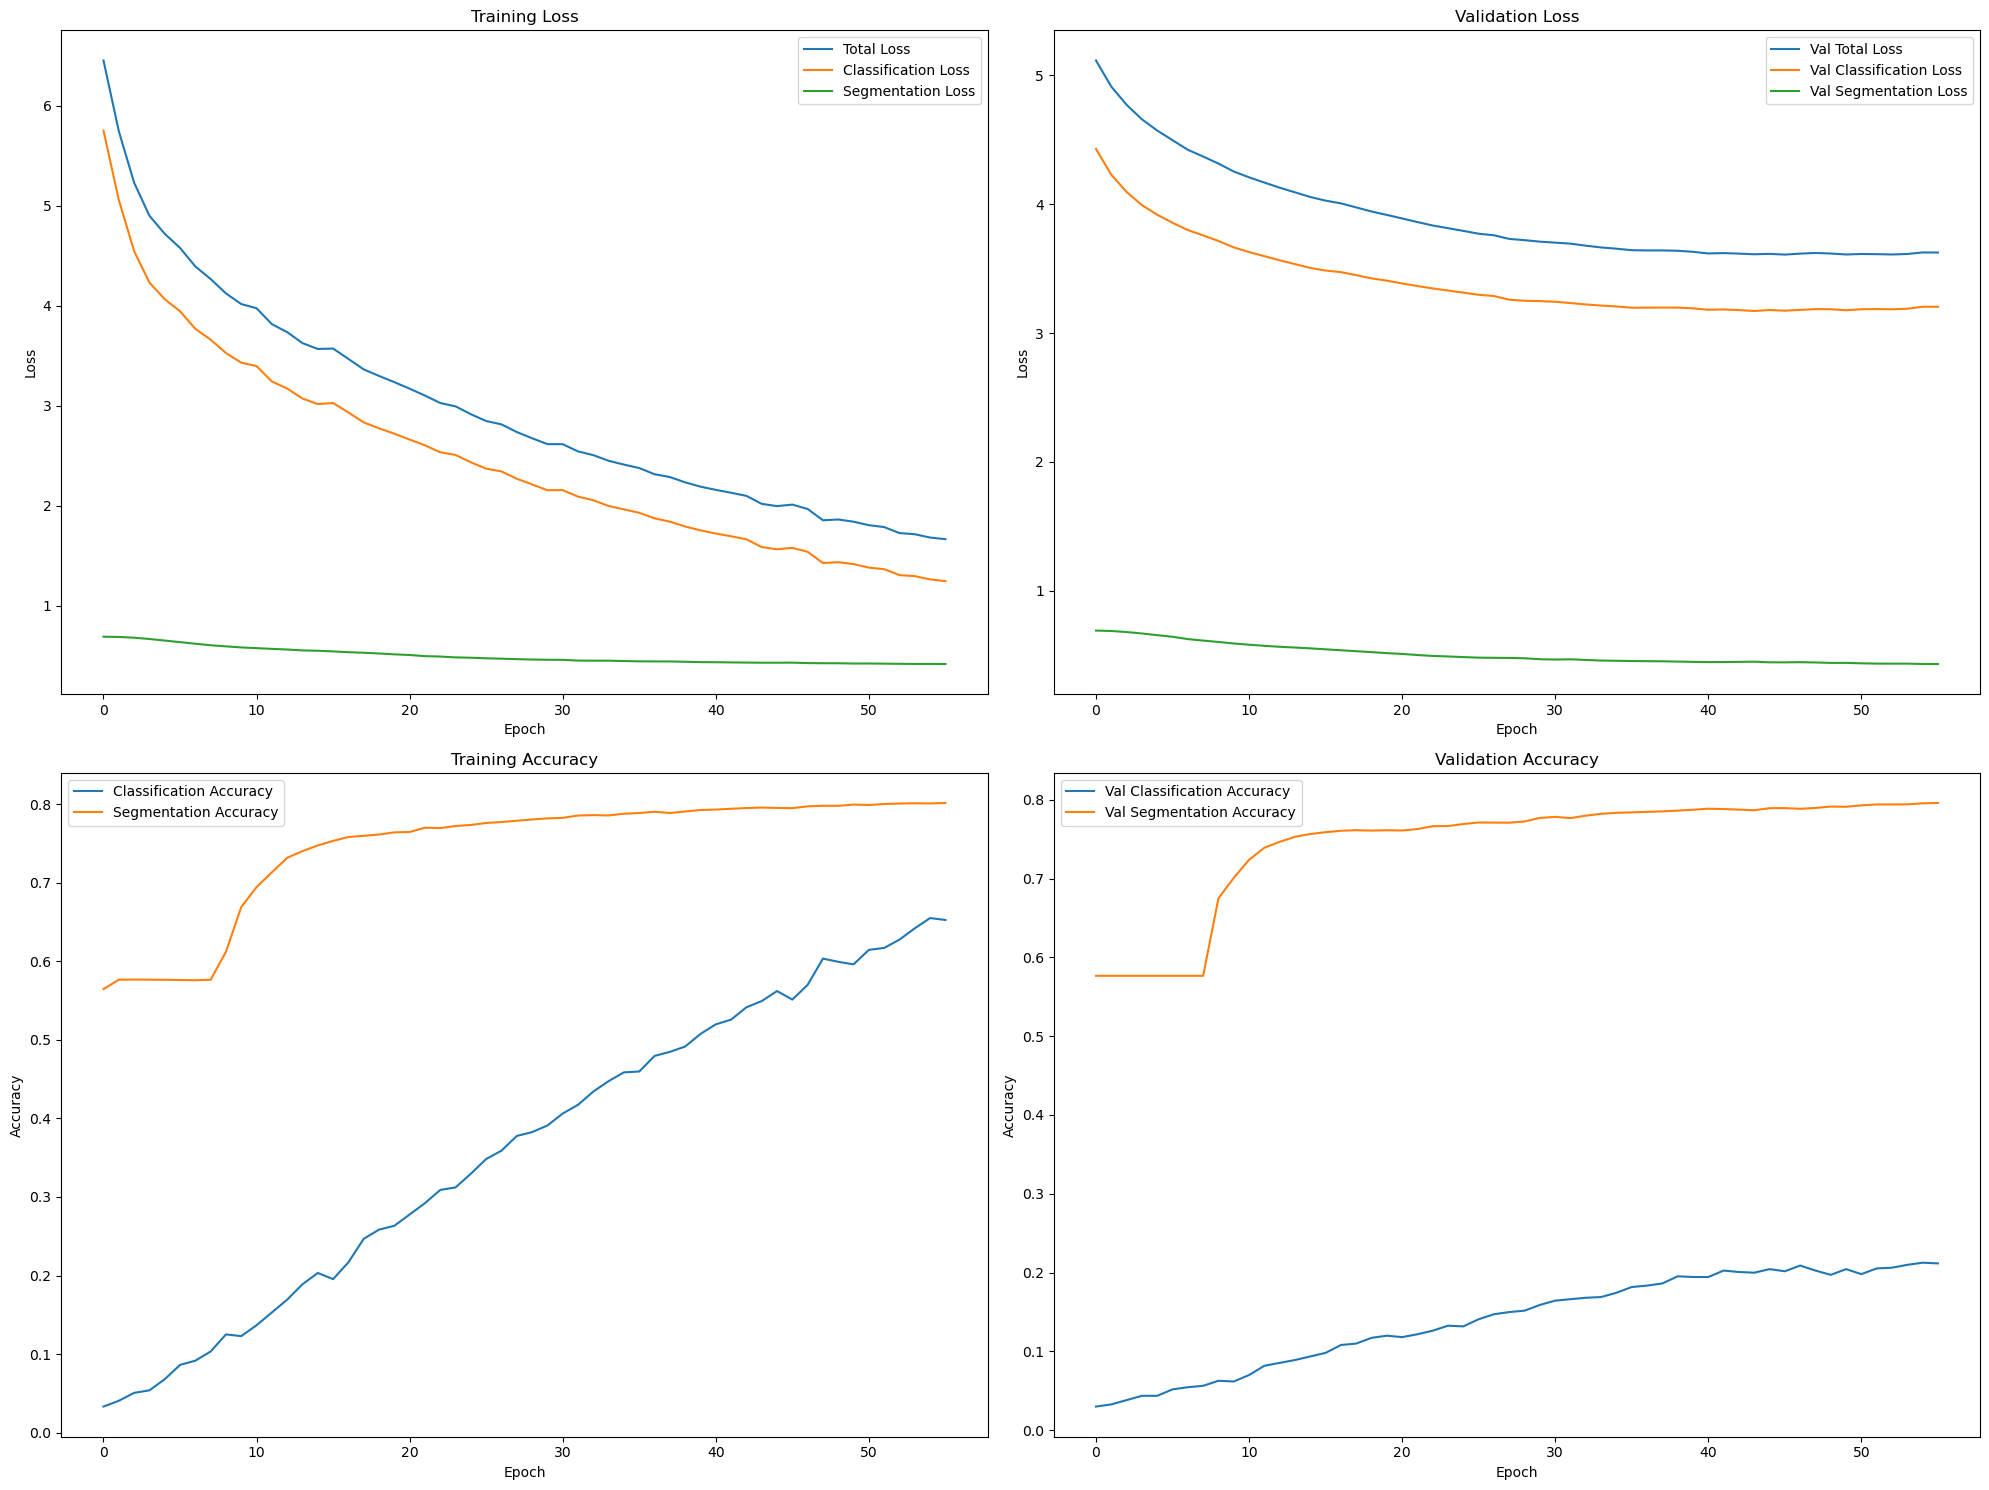

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[20, 15])

# Training losses
ax = fig.add_subplot(2, 2, 1)
ax.plot(mobile_layers.history['loss'], label='Total Loss')
ax.plot(mobile_layers.history['class_output_loss'], label='Classification Loss')
ax.plot(mobile_layers.history['segmentation_output_loss'], label='Segmentation Loss')
ax.set_title('Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# Validation losses
ax = fig.add_subplot(2, 2, 2)
ax.plot(mobile_layers.history['val_loss'], label='Val Total Loss')
ax.plot(mobile_layers.history['val_class_output_loss'], label='Val Classification Loss')
ax.plot(mobile_layers.history['val_segmentation_output_loss'], label='Val Segmentation Loss')
ax.set_title('Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

# Training accuracies
ax = fig.add_subplot(2, 2, 3)
ax.plot(mobile_layers.history['class_output_accuracy'], label='Classification Accuracy')
ax.plot(mobile_layers.history['segmentation_output_accuracy'], label='Segmentation Accuracy')
ax.set_title('Training Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

# Validation accuracies
ax = fig.add_subplot(2, 2, 4)
ax.plot(mobile_layers.history['val_class_output_accuracy'], label='Val Classification Accuracy')
ax.plot(mobile_layers.history['val_segmentation_output_accuracy'], label='Val Segmentation Accuracy')
ax.set_title('Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import f1_score
from keras import backend as K

# List of file names for your saved models
model_files = [
    'Mobile_TrainUnFrozen.keras',
    'Mobile_SmallLearningRateUnFreezeLayers.keras',
    'Mobile_BaseFrozen.keras',
]

# Store the classification losses and classification accuracies for each model
class_losses = []
class_accuracies = []

# Load each model and evaluate
for model_file in model_files:
    model = load_model(model_file)
    
    # Evaluate the model on validation data
    evaluation_metrics = model.evaluate(val_class_seg, verbose=0)
    
    # Extract classification loss and accuracy
    class_loss = evaluation_metrics[1]  # Assuming classification loss is the second element
    class_accuracy = evaluation_metrics[3]  # Assuming classification accuracy is the fourth element
    class_losses.append(class_loss)
    class_accuracies.append(class_accuracy)

# Plot the results

# X-axis values as the model names
x_labels = ['Unfrozen', 'Unfrozen (0.0001 lr)', 'Frozen']

# Plotting classification loss
plt.figure(figsize=(12, 6))

# Plotting classification loss
plt.subplot(1, 2, 1)
plt.plot(x_labels, class_losses, marker='o', color='b', linestyle='-', label='Classification Loss')
plt.title('Classification Loss vs Freezing')
plt.xlabel('Model Type')
plt.ylabel('Classification Loss')
plt.xticks(rotation=90)  # Make x-axis labels vertical
plt.legend()
plt.grid(True)

# Plotting classification accuracy
plt.subplot(1, 2, 2)
plt.plot(x_labels, class_accuracies, marker='o', color='g', linestyle='-', label='Classification Accuracy')
plt.title('Classification Accuracy vs Freezing')
plt.xlabel('Model Type')
plt.ylabel('Classification Accuracy')
plt.xticks(rotation=90)  # Make x-axis labels vertical
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#
# Evaluation
#
# You should evaluate both your networks for both tasks. To help generate metrics and plots, you may want to pull out the labels from the dataset
# which you could do with something like the following:
#
# y_class_test = np.concatenate([y[0] for x,y in test_class_seg.as_numpy_iterator()])
# y_seg_test = np.concatenate([y[1] for x,y in test_class_seg.as_numpy_iterator()])
# 
# For evaluating the two tasks, the classification task is just like all the other classification tasks you've done this semseter and you can follow
# how these have been dealt with. For the segmentation task, one way to look at this is as a binary classification task as you're classifiying each 
# pixel into foreground and background. With that in mind you could do something like this:
#
# class_preds, seg_preds = my_awesome_network.predict(test_class_seg)
# seg_preds_flat = seg_preds.reshape(-1) > 0.5 # flatten predictions, turn into boolean vector where true is fgnd and false is bkgnd
# seg_gt_flat = y_seg_test.reshape(-1) > 0.5 # same as above, but for the ground truth, need to have both as a boolean vector
# cm = sklearn.metrics.confusion_matrix(seg_gt_flat, seg_preds_flat)
#
# You could also look at other segmentation specific metrics as a way to evaluate performance

In [ ]:
# For your write-up, you should include:
# - A discussion of what pre-processing (i.e. resizing, colour conversion, augmentation, etc.) you apply to the data and why.
# - Details of two implemented methods. This should include a details of the final “from-scratch” approach and justification 
#   for the chosen design, and details of changes made to MobileNetV3Small for the “fine-tuned” approach. Details on how the 
#   models are trained are also to be provided. 
# - An evaluation that compares the two models for the two tasks (classification and semantic segmentation). Your evaluation 
#   should discuss overall model performance, how it differs between the two approaches, and include figures if/where necessary.
# - A discussion of methods that were explored to improve performance for both models and mitigate identified issues, and potentially 
#   other methods that were considered but not implemented due to computational constraints. See the assignment brief for further 
#   details.
# Your write-up should be supported by appropriate figures and tables. Figures and tables should have numbers and meaningful captions.
# Note that figures and tables are not included in the page limits.
#
# SEE THE ASSIGNMENT BRIEF ON CANVAS FOR MORE DETAILS AND NOTE THAT A NOTEBOOK FILE DOES NOT CONSTITUTE A VALID SUBMISSION. 
# YOU SHOULD WRITE UP YOUR RESPONSE IN A SEPARATE DOCUMENT

Using Results on the best models
6_ConvLayers_Batch_20Min.keras
Mobile_BaseFrozen.keras

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import backend as K

def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])

    # Predictions for training data
    train_preds = model.predict(X_train)
    train_preds_labels = np.argmax(train_preds, axis=1)  # For classification, convert to class labels
    Y_train_labels = np.argmax(Y_train, axis=1)  # Ground truth labels for classification

    # Confusion matrix for training data
    cm_train = confusion_matrix(Y_train_labels, train_preds_labels)
    ax = fig.add_subplot(1, 2, 1)
    conf_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=np.unique(train_preds_labels))
    conf_train.plot(ax=ax)
    train_accuracy = np.sum(train_preds_labels == Y_train_labels) / len(Y_train_labels)
    ax.set_title(f'Training Set Performance: {train_accuracy:.2f}')

    # Predictions for test data
    test_preds = model.predict(X_test)
    test_preds_labels = np.argmax(test_preds, axis=1)  # For classification, convert to class labels
    Y_test_labels = np.argmax(Y_test, axis=1)  # Ground truth labels for classification

    # Confusion matrix for test data
    cm_test = confusion_matrix(Y_test_labels, test_preds_labels)
    ax = fig.add_subplot(1, 2, 2)
    conf_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=np.unique(test_preds_labels))
    conf_test.plot(ax=ax)
    test_accuracy = np.sum(test_preds_labels == Y_test_labels) / len(Y_test_labels)
    ax.set_title(f'Test Set Performance: {test_accuracy:.2f}')
    
    plt.tight_layout()
    plt.show()

# Example Usage (assuming `model` is a Keras model and `train_embeddings`, `test_embeddings`, etc., are pre-defined):
# eval_model(model, train_embeddings, train_labels, test_embeddings, test_labels)

# Pre Trained

1.830397129058838
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step
Segmentation Confusion Matrix:
[[5190210  865951]
 [1116048 3346319]]


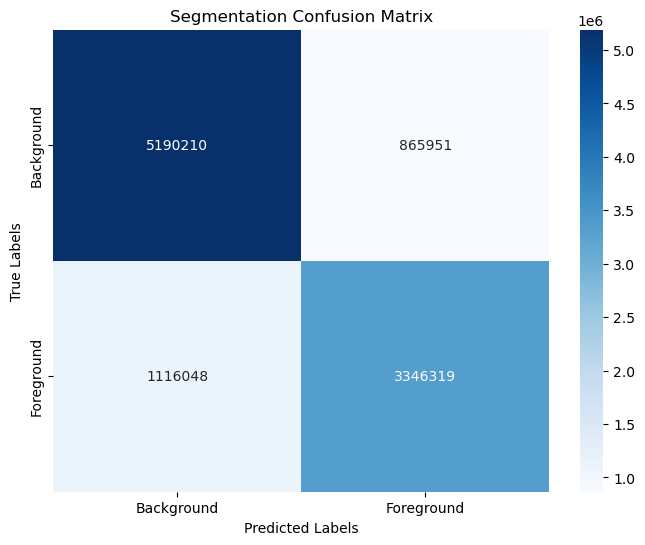

Segmentation Accuracy: 0.8116
Segmentation F1 Score: 0.7715
Segmentation Precision: 0.7944
Segmentation Recall: 0.7499


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import seaborn as sns
from keras.models import load_model
import sklearn
import time

# Load the model (Mobile_BaseFrozen in this case)
model = load_model('Mobile_BaseFrozen.keras')  # Change with your actual model file
start = time.time()
# Get the test dataset (assuming `test_class_seg` is your test data and `val_class_seg` is your validation data)
y_seg_test = np.concatenate([y[1] for x, y in test_class_seg.as_numpy_iterator()])
end = time.time()
print(end-start)

# Make predictions for segmentation task
_, seg_preds = model.predict(test_class_seg)

# Flatten segmentation predictions and ground truth to calculate confusion matrix for segmentation
seg_preds_flat = seg_preds.reshape(-1) > 0.5  # Binarize segmentation predictions
seg_gt_flat = y_seg_test.reshape(-1) > 0.5  # Binarize segmentation ground truth

# Confusion matrix for segmentation
cm_segmentation = confusion_matrix(seg_gt_flat, seg_preds_flat)
print(f"Segmentation Confusion Matrix:\n{cm_segmentation}")

# Plotting confusion matrix for segmentation
plt.figure(figsize=(8, 6))
sns.heatmap(cm_segmentation, annot=True, fmt='d', cmap='Blues', xticklabels=["Background", "Foreground"], yticklabels=["Background", "Foreground"])
plt.title("Segmentation Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Segmentation Metrics: Accuracy, F1 Score, Precision
seg_accuracy = accuracy_score(seg_gt_flat, seg_preds_flat)
seg_f1 = f1_score(seg_gt_flat, seg_preds_flat)
seg_precision = precision_score(seg_gt_flat, seg_preds_flat)
seg_recall = recall_score(seg_gt_flat, seg_preds_flat)
print(f"Segmentation Accuracy: {seg_accuracy:.4f}")
print(f"Segmentation F1 Score: {seg_f1:.4f}")
print(f"Segmentation Precision: {seg_precision:.4f}")
print(f"Segmentation Recall: {seg_recall:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step


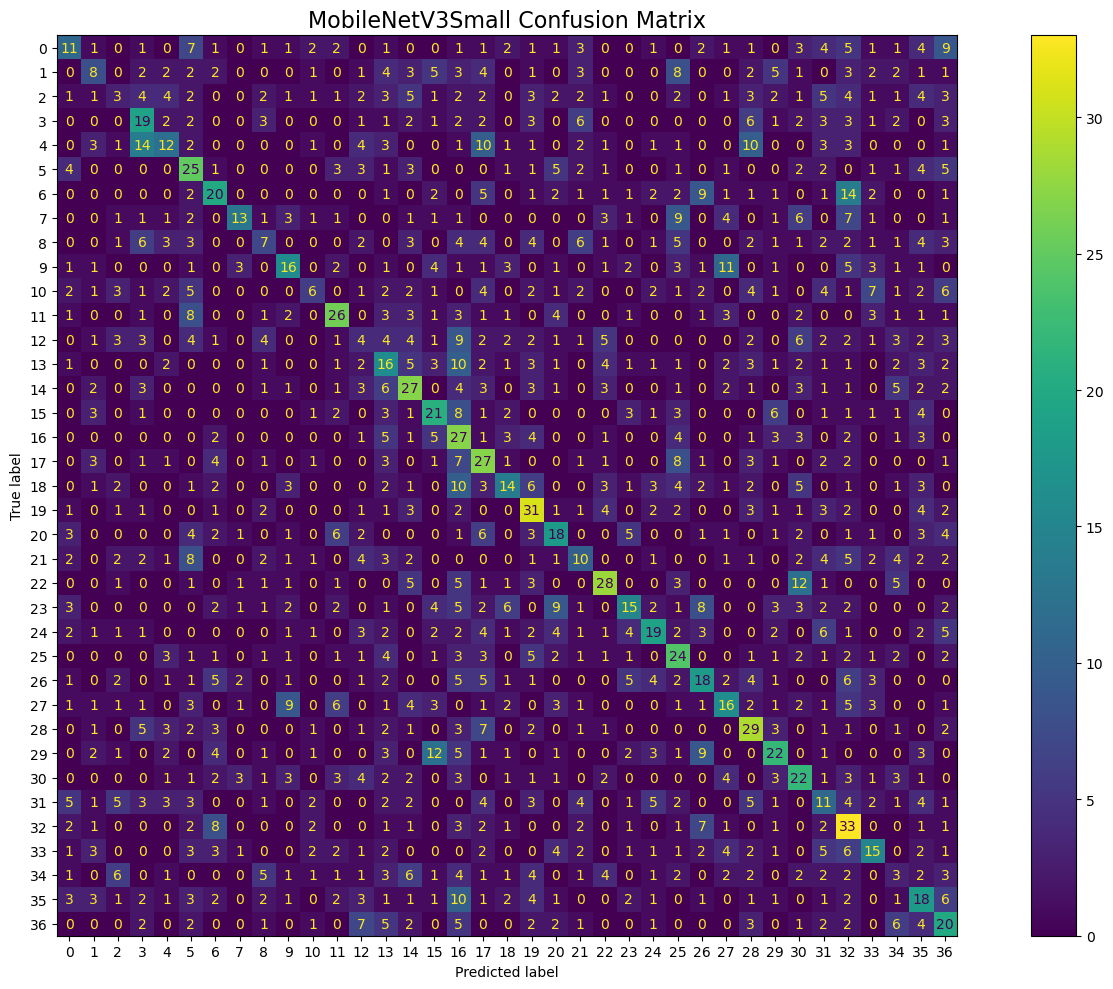

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score,ConfusionMatrixDisplay, recall_score
import seaborn as sns
from keras.models import load_model
import sklearn

# Load the model (Mobile_BaseFrozen in this case)
model = load_model('Mobile_BaseFrozen.keras')  # Change with your actual model file

# Get the test dataset (assuming `test_class_seg` is your test data and `val_class_seg` is your validation data)
y_class_test = np.concatenate([y[0] for x, y in test_class_seg.as_numpy_iterator()])

# Make predictions for segmentation task
class_pred, seg_pred = model.predict(test_class_seg)

class_preds_labels = np.argmax(class_pred, axis=-1)  # Convert probabilities to predicted class labels

cm = confusion_matrix(y_class_test,class_preds_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(15, 10)) # Adjust dimensions as needed
disp.plot(ax=ax, cmap=plt.cm.viridis) # You can choose other colormaps like 'viridis', 'plasma', etc.
plt.title("MobileNetV3Small Confusion Matrix", fontsize=16) # <--- THIS LINE ADDS THE TITLE
plt.tight_layout()
plt.show()

# Calculate accuracy, precision, recall, and F1 score

accuracy = accuracy_score(y_class_test, class_preds_labels)
precision = precision_score(y_class_test, class_preds_labels, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_class_test, class_preds_labels, average='weighted')  # Use 'weighted' for multi-class
f1 = f1_score(y_class_test, class_preds_labels, average='weighted')  # Use 'weighted' for multi-class

In [12]:
# Calculate accuracy, precision, recall, and F1 score

accuracy = accuracy_score(y_class_test, class_preds_labels)
precision = precision_score(y_class_test, class_preds_labels, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_class_test, class_preds_labels, average='weighted')  # Use 'weighted' for multi-class
f1 = f1_score(y_class_test, class_preds_labels, average='weighted')  # Use 'weighted' for multi-class

# Print the scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.2547
Precision: 0.2572
Recall: 0.2547
F1 Score: 0.2472


# Custom Made

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step
7.581563472747803
Segmentation Confusion Matrix:
[[4990956 1065205]
 [1458249 3004118]]


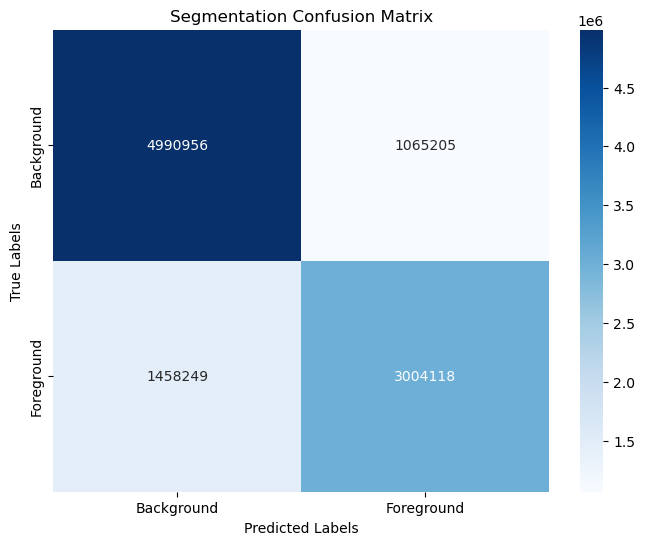

Segmentation Accuracy: 0.7601
Segmentation F1 Score: 0.7042
Segmentation Precision: 0.7382
Segmentation Recall: 0.6732


In [14]:
# Load the model (Mobile_BaseFrozen in this case)
import time
model = load_model('6_ConvLayers_Batch_20Min.keras')  # Change with your actual model file

# Get the test dataset (assuming `test_class_seg` is your test data and `val_class_seg` is your validation data)
y_seg_test = np.concatenate([y[1] for x, y in test_class_seg.as_numpy_iterator()])
start = time.time()
# Make predictions for segmentation task
_, seg_preds = model.predict(test_class_seg)
end = time.time()
print(end-start)

# Flatten segmentation predictions and ground truth to calculate confusion matrix for segmentation
seg_preds_flat = seg_preds.reshape(-1) > 0.5  # Binarize segmentation predictions
seg_gt_flat = y_seg_test.reshape(-1) > 0.5  # Binarize segmentation ground truth

# Confusion matrix for segmentation
cm_segmentation = confusion_matrix(seg_gt_flat, seg_preds_flat)
print(f"Segmentation Confusion Matrix:\n{cm_segmentation}")

# Plotting confusion matrix for segmentation
plt.figure(figsize=(8, 6))
sns.heatmap(cm_segmentation, annot=True, fmt='d', cmap='Blues', xticklabels=["Background", "Foreground"], yticklabels=["Background", "Foreground"])
plt.title("Segmentation Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Segmentation Metrics: Accuracy, F1 Score, Precision
seg_accuracy = accuracy_score(seg_gt_flat, seg_preds_flat)
seg_f1 = f1_score(seg_gt_flat, seg_preds_flat)
seg_precision = precision_score(seg_gt_flat, seg_preds_flat)
seg_recall = recall_score(seg_gt_flat, seg_preds_flat)

print(f"Segmentation Accuracy: {seg_accuracy:.4f}")
print(f"Segmentation F1 Score: {seg_f1:.4f}")
print(f"Segmentation Precision: {seg_precision:.4f}")
print(f"Segmentation Recall: {seg_recall:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step


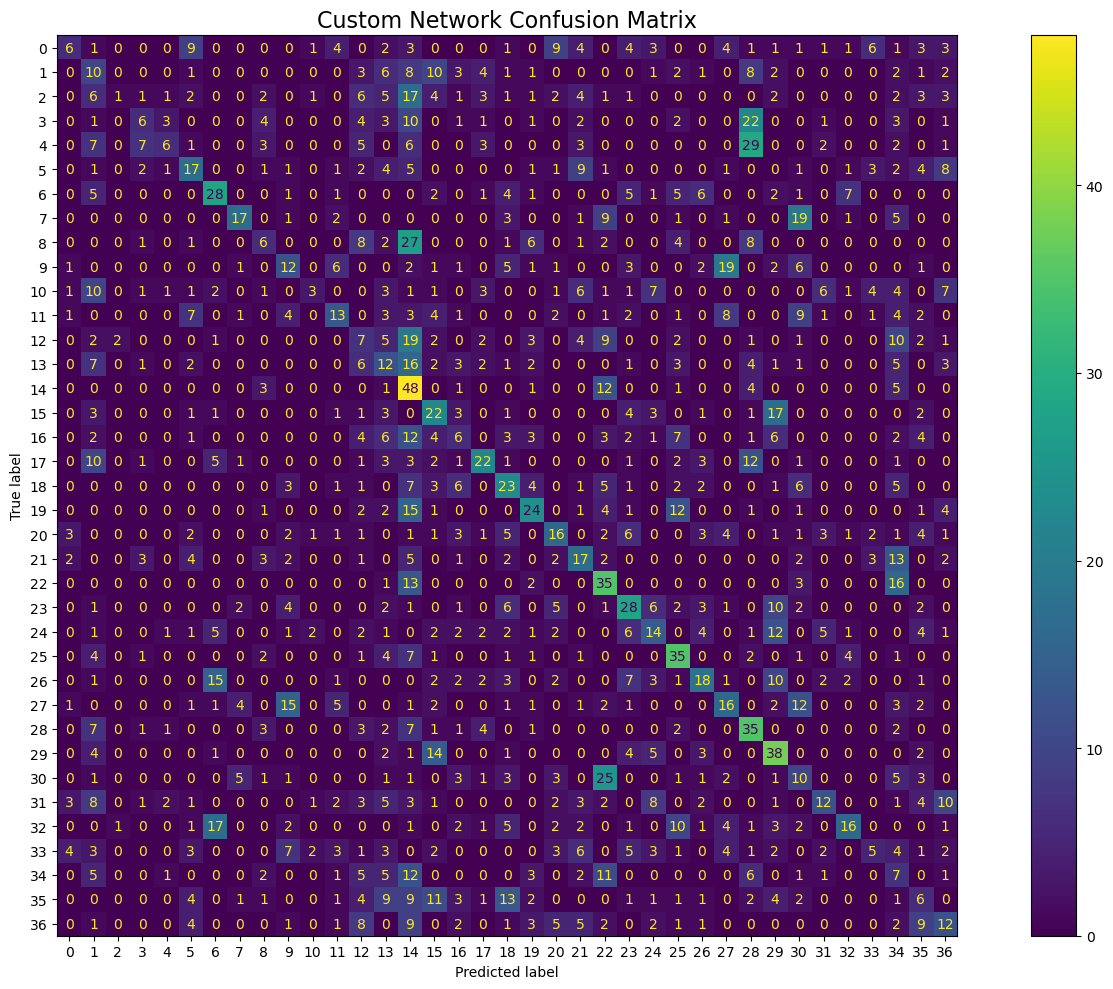

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score,ConfusionMatrixDisplay, recall_score
import seaborn as sns
from keras.models import load_model
import sklearn

# Load the model (Mobile_BaseFrozen in this case)
model = load_model('6_ConvLayers_Batch_20Min.keras')  # Change with your actual model file

# Get the test dataset (assuming `test_class_seg` is your test data and `val_class_seg` is your validation data)
y_class_test = np.concatenate([y[0] for x, y in test_class_seg.as_numpy_iterator()])

# Make predictions for segmentation task
class_pred, seg_pred = model.predict(test_class_seg)

class_preds_labels = np.argmax(class_pred, axis=-1)  # Convert probabilities to predicted class labels

cm = confusion_matrix(y_class_test,class_preds_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(15, 10)) # Adjust dimensions as needed
disp.plot(ax=ax, cmap=plt.cm.viridis) # You can choose other colormaps like 'viridis', 'plasma', etc.
plt.title("Custom Network Confusion Matrix", fontsize=16) # <--- THIS LINE ADDS THE TITLE
plt.tight_layout()
plt.show()

# Calculate accuracy, precision, recall, and F1 score

accuracy = accuracy_score(y_class_test, class_preds_labels)
precision = precision_score(y_class_test, class_preds_labels, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_class_test, class_preds_labels, average='weighted')  # Use 'weighted' for multi-class
f1 = f1_score(y_class_test, class_preds_labels, average='weighted')  # Use 'weighted' for multi-class

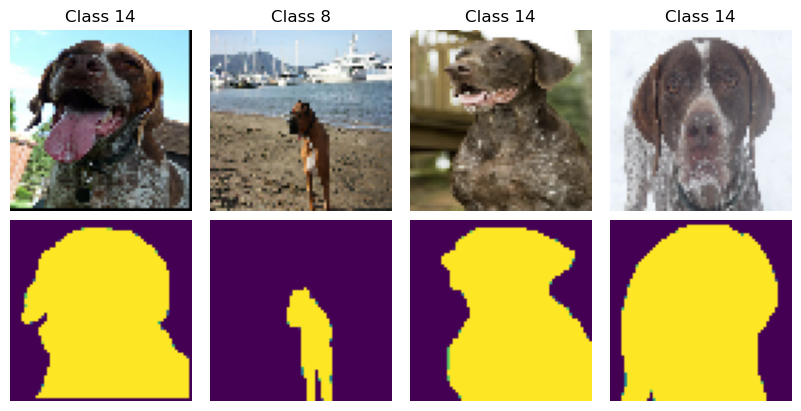

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Number of image pairs to plot
num_plot = 4

# Class pair to compare: (4, 28)
class_pairs = [(8, 14)]

# Create a figure for plotting
fig, axs = plt.subplots(2, num_plot, figsize=(8, 4), layout="constrained")

# Counter for plotting images
i = 0

# Iterate through the dataset
for image, output in train_class_seg.take(1).as_numpy_iterator():
    # Iterate through the class pairs
    for class_1, class_2 in class_pairs:
        # Find images belonging to class_1 or class_2
        for idx in range(image.shape[0]):
            class_label = output[0][idx]
            
            # If the class label matches either class_1 or class_2, plot the image and segmentation mask
            if class_label == class_1 or class_label == class_2:
                im = axs[0, i].imshow(np.squeeze(unprocess_image(image[idx, ...])) / 255.0)
                axs[0, i].set_title(f"Class {class_label}")
                axs[0, i].axis('off')
                
                # Plot the segmentation mask
                im = axs[1, i].imshow(np.squeeze(output[1][idx, ...]))
                axs[1, i].axis('off')
                
                i += 1

            if i >= num_plot:  # Stop when we've plotted the required number of pairs
                break
        
        if i >= num_plot:  # Stop the outer loop as well when we've plotted the required number of images
            break
    
    if i >= num_plot:  # Stop the dataset iteration if we have enough images
        break

# Save the image
plt.savefig('class_8_vs_14_comparison.png')
plt.show()
